In [ ]:
''''
for patient_num in range(8863, 9084):  # Note that the upper limit is one more than your max to include it
    patient_path = os.path.join(base_path, str(patient_num))
    print(patient_num)
    # Check if patient folder exists
    if not os.path.exists(patient_path):
        # Skip this patient number if the folder does not exist
        continue

    # If the patient folder exists, check for '0' or '1' folders and their contents
    class_0_path = os.path.join(patient_path, '0')
    class_1_path = os.path.join(patient_path, '1')

    # Check if either class folder is empty or does not exist
    if not (os.path.exists(class_0_path) and os.listdir(class_0_path)) or \
       not (os.path.exists(class_1_path) and os.listdir(class_1_path)):
        # Skip this patient if either folder does not exist or is empty
        continue

    for class_folder in ['0', '1']:
        class_path = os.path.join(patient_path, class_folder)
        for image_filename in os.listdir(class_path):
            image_path = os.path.join(class_path, image_filename)
            features.append(preprocess_and_extract_features(image_path))
            labels.append(int(class_folder))


In [ ]:
# Given proportions from the confusion matrix
TP = 0.786722
TN = 0.822978
FP = 0.177022
FN = 0.213278

# Calculations
accuracy = (TP + TN) / 2
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

accuracy, precision, recall, specificity, f1_score

(0.8048500000000001,
 0.8163184414118272,
 0.786722,
 0.822978,
 0.8012470057196865)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
#Step 2 - Load the data
mnist = fetch_openml('mnist_784')
#Step 3 - Let's check the shape of the data
print("Size of data:", mnist.data.shape)
print("Size of labels:", mnist.target.shape)

In [ ]:
#Turn the first image in MNIST data to a numpy object
some_digit = mnist.data.to_numpy()[0]
# Now reshape to plot the image (pixels 28x28)
some_digit_image = some_digit.reshape(28, 28)
#Plot our selected number with the label
plt.imshow(some_digit_image, cmap=plt.cm.binary, interpolation='nearest')
plt.axis()
plt.title(mnist.target[0])
plt.show()

In [ ]:
#Split the MNIST data into training and test data
train_image, test_image, train_label, test_label = train_test_split(mnist.data, mnist.target, test_size=1/7, random_state=42)
#Instantiate model
#Here I changed the solver for it to handle multinomial loss
log_regression = LogisticRegression(solver='saga')
#Fit the model and train
log_regression.fit(train_image, train_label)
#Let us measure performance
score = log_regression.score(test_image, test_label)
print("The accuracy score is:", score*100)

In [ ]:
# Make predictions on entire test data
y_prediction = log_regression.predict(test_image)
#Create a confusion matrix
matrix = metrics.confusion_matrix(test_label, y_prediction)
#Visualize the matrix with Seaborn
#Write title to display accuracy score
all_sample_title = 'Accuracy Score: {0}'.format(score)
#Set figure shape
plt.figure(figsize=(9,9))
#Use heatmap
sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=0.5, square=True, cmap="mako")
#Label the plot
plt.ylabel('Actual Label', size=12)
plt.xlabel('Predicted Label', size = 12)
plt.title(all_sample_title, size = 16)

In [ ]:
#print classification report
print(classification_report(test_label, y_prediction))

# SVM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
from skimage.feature import hog
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

In [ ]:
patient_num = ['8914','8916','8917','8918']
for patient in patient_num:
  patient_path = os.path.join(base_path, patient)
  for class_folder in ['0', '1']:
      class_path = os.path.join(patient_path, class_folder)
      for image_filename in os.listdir(class_path):
        image_path = os.path.join(class_path, image_filename)

        features.append(preprocess_and_extract_features(image_path))
        labels.append(int(class_folder))

In [ ]:
base_path = "/content/drive/My Drive/Hardis_Data/"

features = []
labels = []

def preprocess_and_extract_features(image_path):

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_features = hog(gray_img, orientations=30, pixels_per_cell=(5, 5), cells_per_block=(2, 2), block_norm='L2')
    return hog_features

In [ ]:
features = np.array(features)
labels = np.array(labels)

ros = RandomOverSampler(random_state=42)
features_resampled, labels_resampled = ros.fit_resample(features, labels)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_resampled)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_resampled, test_size=0.2, random_state=42)

clf = svm.SVC(kernel='linear', probability = True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3740,) + inhomogeneous part.

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

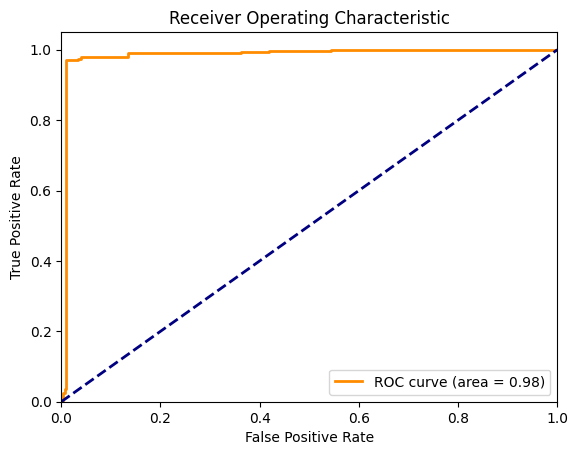

In [ ]:
y_scores = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[247  49]
 [  3 295]]


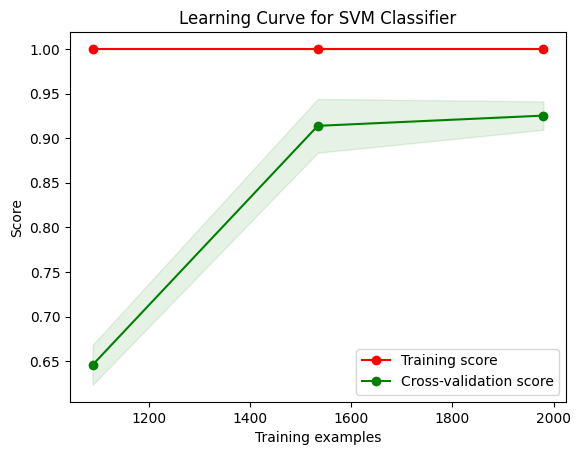

In [ ]:
from sklearn.model_selection import learning_curve
# Decide the range of data sizes for which you want to plot the learning curves
train_sizes = np.linspace(0.1, 1.0, 5)

# Compute the learning curves with cross-validation
train_sizes, train_scores, valid_scores = learning_curve(
    clf, features_scaled, labels_resampled, train_sizes=train_sizes, cv=3, n_jobs=-1, random_state=42
)

# Calculate the average and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve for SVM Classifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()